In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from vasopressor.preprocess_helpers import load_and_create_MIMIC_dataloader
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection, get_top_features_per_concept

gpu_id = int(subprocess.check_output('nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1 | head -n 1 | xargs', shell=True, text=True))
device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available else torch.device('cpu')
print("current device", device)

current device cuda:15


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [4]:
seq_len = seq_len
changing_dim = len(changing_vars)
static_dim = len(static_names)

print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)


27 8 6


## Optimization

In [10]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original_new/"

def get_model(random_seed):
    # feature weights
    config_original = {
        "n_concepts": 4,
        "use_indicators": True,
        "use_only_last_timestep": False,
    }
    
    experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/original_new/"
    model_path = get_filename_from_dict(experiment_folder, config_original)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

    top_k = "" # "/workdir/optimal-summaries-public/_models/vasopressor/original/top-k/bottleneck_topkinds.csv"

    model = models_original.CBM(**config_original, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=top_k, device=device)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_original, seed = random_seed), max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model = get_model(4)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  3%|▎         | 270/10000 [03:43<2:14:03,  1.21 epoch/s, Train Loss=0.48658, Val Loss=0.51961, Best Val Loss=0.51538]

Early Stopped


AUC macro 0.9211000204086304
ACC macro 0.8486356735229492
 F1 macro 0.8560000061988831


In [6]:
abs_bottleneck_weights = model.bottleneck.weight.cpu().detach().numpy()
abs_bottleneck_weights = np.abs(abs_bottleneck_weights)
abs_bottleneck_weights.shape


(4, 656)

In [7]:
threshold = 1e-4  # Threshold value

# Iterate over each row (dimension)
for row_idx in range(abs_bottleneck_weights.shape[0]):
    # Select weights bigger than the threshold for the current row
    selected_weights = abs_bottleneck_weights[row_idx][abs_bottleneck_weights[row_idx] < threshold]
    
    # Print the selected weights for the current row
    print(f"Row {row_idx + 1}: Selected weights smaller than threshold ({threshold}):")
    # print(selected_weights)
    print(len(selected_weights))


Row 1: Selected weights smaller than threshold (0.0001):
122
Row 2: Selected weights smaller than threshold (0.0001):
62
Row 3: Selected weights smaller than threshold (0.0001):
35
Row 4: Selected weights smaller than threshold (0.0001):
59


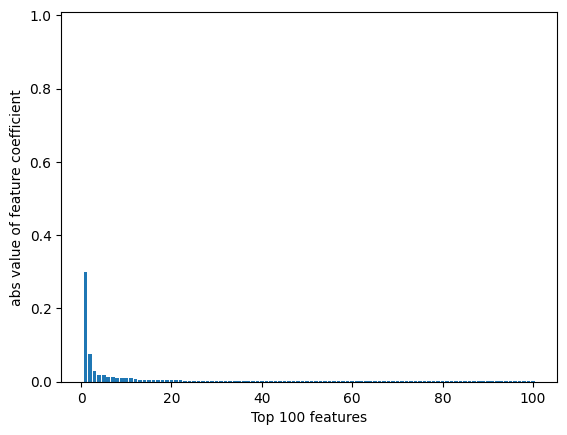

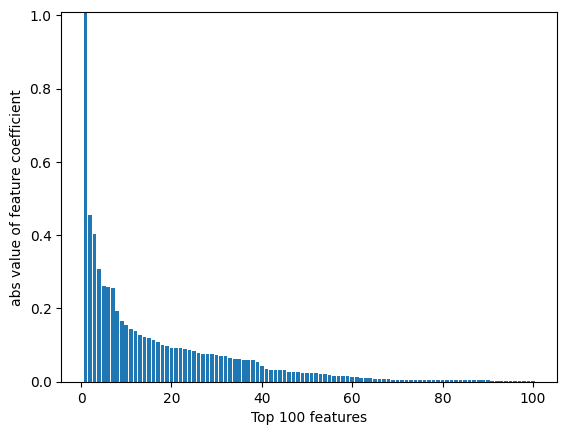

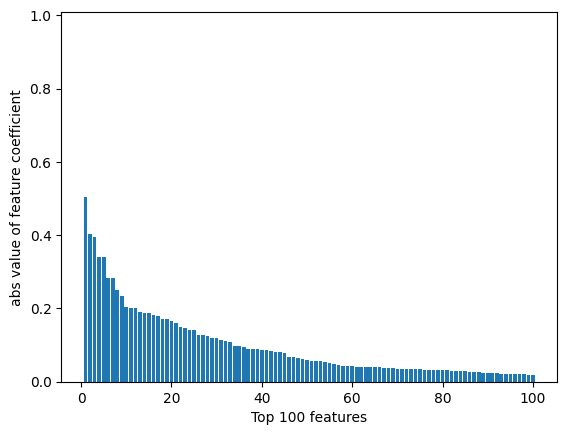

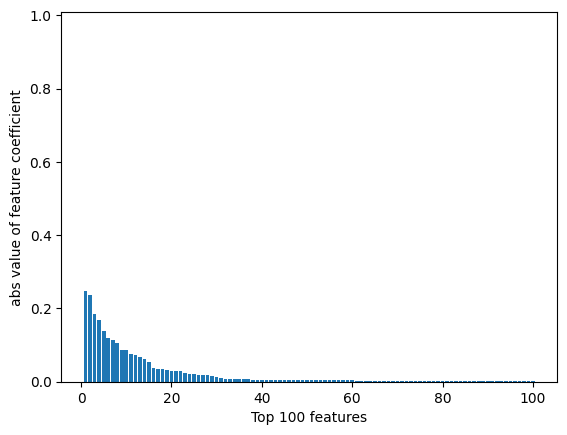

In [8]:
visualize_top100_weights_per_channel(model.bottleneck)


In [11]:
top_k_inds = get_top_features_per_concept(model.bottleneck)
# top_k_inds
model.layer_output.weight

Found 4 Concepts
90th percentile per concept [0.80630976 6.4686685  9.836348   2.5116637 ]
['Concept 0 len: 238', 'Concept 1 len: 56', 'Concept 2 len: 99', 'Concept 3 len: 130']


Parameter containing:
tensor([[ 0.8610,  2.3126,  3.4860, -1.4506],
        [-0.5501, -2.2258, -3.4838,  2.0821]], device='cuda:15',
       requires_grad=True)

In [ ]:
# write top k inds to csv
top_k_file = experiment_folder + "top-k/top_k_idx.csv"
print(top_k_file)

print(len(top_k_inds))
[print(len(x)) for x in top_k_inds]

df = pd.DataFrame(top_k_inds).T
# write_df_2_csv(top_k_file, df)

# read_df_from_csv()
lists = df.apply(lambda x: x.dropna().tolist()).tolist()
print(len(lists))
[print(len(x)) for x in lists]

# directory = os.path.dirname(top_k_file)
# if not os.path.exists(directory):
#     os.makedirs(directory)

# # writing to csv file 
# with open(top_k_file, 'w') as csvfile: 
#     # creating a csv writer object 
#     csvwriter = csv.writer(csvfile)
#     # writing the data rows 
#     csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = seq_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [29]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

models = [get_model(seed) for seed in range(1,4)]

results = []
for seed, model in enumerate(models, 1):
    print("seed", seed)
    top_k_inds = get_top_features_per_concept(model.bottleneck)
    
    greedy_results = greedy_forward_selection(model=model, layers_to_prune=[model.bottleneck], top_k_inds=[top_k_inds], val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
    greedy_results['Merged'] = greedy_results['Layer'].astype(str) + '_' + greedy_results['Concept'].astype(str) + '_' + greedy_results['Feature'].astype(str)
    results.append(greedy_results)
    
    top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds_seed_{seed}.csv".format(seed=seed)

    write_df_2_csv(top_k_csv_file, greedy_results)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_1.pt
AUC macro 0.9131898880004883
ACC macro 0.8352497220039368
 F1 macro 0.8434697389602661


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_2.pt
AUC macro 0.9151526093482971
ACC macro 0.8385961651802063
 F1 macro 0.846611738204956


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/original_new/n_concepts_4_use_indicators_True_use_only_last_timestep_False_seed_3.pt
AUC macro 0.9143695831298828
ACC macro 0.8337909579277039
 F1 macro 0.8420966863632202
1
2
Found 4 Concepts
90th percentile per concept [7.7694016 1.8362296 3.104334  7.6339426]
['Concept 0 len: 80', 'Concept 1 len: 146', 'Concept 2 len: 122', 'Concept 3 len: 83']


100%|██████████| 40/40 [2:05:51<00:00, 188.80s/it, Score=0.92628, acc=0.864, f1=0.868, auc=0.926]  


3
Found 4 Concepts
90th percentile per concept [ 0.689293  7.083639 10.341766  1.816546]
['Concept 0 len: 297', 'Concept 1 len: 62', 'Concept 2 len: 108', 'Concept 3 len: 140']


100%|██████████| 40/40 [3:16:09<00:00, 294.23s/it, Score=0.92914, acc=0.86, f1=0.867, auc=0.929]   


In [30]:
res = read_df_from_csv("/workdir/optimal-summaries-public/_models/vasopressor/original_new/top-k/bottleneck_topkinds_1.csv")

results.insert(0, res)
len(results)


3

In [16]:
pd.set_option('display.max_rows', 100)
greedy_results

,Score,Layer,Concept,Feature,acc,f1,auc,Merged
0,0.903700,0,2,537,0.777368,0.808558,0.903700,0_2_537
1,0.912953,0,2,626,0.815975,0.834682,0.912953,0_2_626
2,0.914918,0,2,76,0.817090,0.835671,0.914918,0_2_76
3,0.916148,0,1,265,0.852351,0.860024,0.916148,0_1_265
4,0.916843,0,0,362,0.851235,0.859459,0.916843,0_0_362
5,0.917527,0,2,612,0.860072,0.864816,0.917527,0_2_612
6,0.918248,0,0,376,0.854839,0.861832,0.918248,0_0_376
7,0.919124,0,1,123,0.852522,0.859845,0.919124,0_1_123
8,0.919763,0,2,557,0.850721,0.858283,0.919763,0_2_557
9,0.920141,0,2,165,0.848576,0.856958,0.920141,0_2_165


In [14]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds.csv" #_r{}_c{}   .format(random_seed, n_concepts)

write_df_2_csv(top_k_csv_file, greedy_results)


In [21]:
len(results)

3

In [52]:

def plot_selected_weights(weight, greedy_results):
    abs_weight = weight.detach().cpu().numpy()
    abs_weight = np.abs(abs_weight)
    
    n_concepts = abs_weight.shape[0]
    max_y = np.max(abs_weight)
    
    fig, axs = plt.subplots(n_concepts, figsize=(8, 2 * n_concepts))
    
    for c in range(n_concepts):
        ax = axs[c]
        
        inds = np.argsort(-abs_weight[c])[:100]
        
        selected_features = greedy_results[greedy_results["Concept"] == c]["Feature"].to_list()
        colors = ['red' if i in selected_features else 'gray' for i in inds]
        ax.bar(np.arange(1, 101), abs_weight[c][inds], color=colors)
        
        ax.set_title(f"Concept {c + 1}")
        # ax.set_xlabel("Top 100 features")
        # ax.set_ylabel("abs value of feature coefficient")
        ax.set_ylim(0, max_y)
        ax.set_yscale('log')
        
        ax.legend(['Selected', 'Not Selected'])
    
    plt.xlabel("Top 100 features")
    plt.ylabel("abs value of feature coefficient")
    plt.tight_layout()
    plt.show()



torch.Size([4, 656, 3])


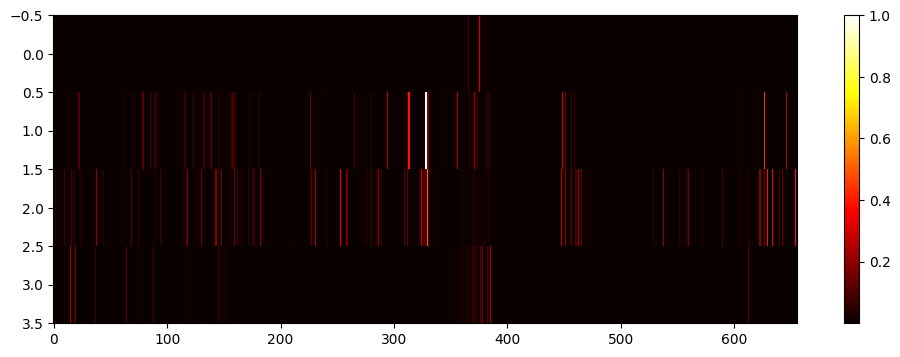

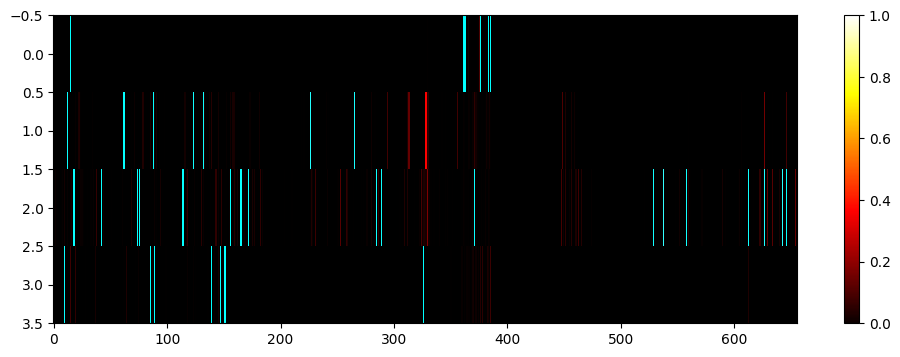

1.0

In [93]:
mask = torch.zeros(model.bottleneck.weight.size(), dtype=torch.float)

for c, f in zip(results[0]["Concept"], results[0]["Feature"]):
    mask[c,f] = 1

weight = torch.abs(model.bottleneck.weight.detach().cpu())
weight = weight / torch.max(weight)

test = torch.stack([weight, mask, mask], dim=-1)
print(test.shape)

for df in results:
    plt.figure(figsize=(12, 4))
    plt.imshow(weight, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.imshow(test, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.show()
    
    break
    
selected_feats = [df["Merged"].to_list() for df in results]
jaccard_similarity(*selected_feats)


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, class_weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()

## Shared

In [19]:
experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/model3d/"

def get_model(random_seed):
    # feature weights
    config = {
        "n_concepts": 4,
        "use_indicators": True,
        "encode_time_dim": False,
    }
    
    experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/model3d/"
    makedir(experiment_folder)
    model_path = get_filename_from_dict(experiment_folder, config)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

    top_k = "" # "/workdir/optimal-summaries-public/_models/vasopressor/original/top-k/bottleneck_topkinds.csv"

    model = models_3d.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=top_k, device=device)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)

    evaluate_classification(model, test_loader, num_classes=num_classes, device=device)
    return model

model = get_model(1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 3/10000 [00:02<2:35:24,  1.07 epoch/s, Train Loss=0.61076, Val Loss=0.62133, Best Val Loss=0.62133]

  3%|▎         | 270/10000 [03:47<2:16:47,  1.19 epoch/s, Train Loss=0.48101, Val Loss=0.51377, Best Val Loss=0.51309]

Early Stopped


AUC macro 0.9149039387702942
ACC macro 0.8420284986495972
 F1 macro 0.8498246073722839


In [20]:
models = [get_model(i) for i in range(1,4)]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/model3d/n_concepts_4_use_indicators_True_encode_time_dim_False_seed_1.pt
AUC macro 0.9126362800598145
ACC macro 0.8398833274841309
 F1 macro 0.8479465246200562


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 2/10000 [00:01<2:35:23,  1.07 epoch/s, Train Loss=0.62038, Val Loss=0.62227, Best Val Loss=0.62227]

 11%|█         | 1090/10000 [17:44<2:24:59,  1.02 epoch/s, Train Loss=0.47626, Val Loss=0.49628, Best Val Loss=0.49478]

Early Stopped


AUC macro 0.9194375276565552
ACC macro 0.8446027040481567
 F1 macro 0.8515938520431519


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  5%|▌         | 530/10000 [07:37<2:16:08,  1.16 epoch/s, Train Loss=0.48340, Val Loss=0.49649, Best Val Loss=0.49610]

Early Stopped


AUC macro 0.9190932512283325
ACC macro 0.8443452715873718
 F1 macro 0.8512626886367798


In [22]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

top_k_folder = add_subfolder(experiment_folder)
makedir(top_k_folder)

for seed, model in enumerate(models, 1):
    top_k_inds = [get_top_features_per_concept(layer) for layer in model.regularized_layers]
    save_path = top_k_folder + "bottleneck_topkinds_encode_time_dim_False_{seed}.csv".format(seed=seed)
    print("save_path", save_path)
    
    greedy_results_atomics = greedy_forward_selection(model=model, layers_to_prune=model.regularized_layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics, path=save_path)
    greedy_results_atomics


Found 4 Concepts
90th percentile per concept [0.9659492 3.4610431 1.890879  1.8960611]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 11', 'Concept 3 len: 13']
save_path /workdir/optimal-summaries-public/_models/vasopressor/model3d/top-k/bottleneck_topkinds_encode_time_dim_False_1.csv


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [08:31<00:00, 12.79s/it, Score=0.92540, acc=0.86, f1=0.865, auc=0.925] 


Found 4 Concepts
90th percentile per concept [2.07826   1.6157607 2.6154482 1.4065777]
['Concept 0 len: 13', 'Concept 1 len: 10', 'Concept 2 len: 12', 'Concept 3 len: 10']
save_path /workdir/optimal-summaries-public/_models/vasopressor/model3d/top-k/bottleneck_topkinds_encode_time_dim_False_2.csv


100%|██████████| 40/40 [08:47<00:00, 13.18s/it, Score=0.92832, acc=0.861, f1=0.866, auc=0.928]


Found 4 Concepts
90th percentile per concept [2.3686588 2.2770405 1.9033036 1.4596194]
['Concept 0 len: 10', 'Concept 1 len: 11', 'Concept 2 len: 12', 'Concept 3 len: 11']
save_path /workdir/optimal-summaries-public/_models/vasopressor/model3d/top-k/bottleneck_topkinds_encode_time_dim_False_3.csv


100%|██████████| 40/40 [08:28<00:00, 12.71s/it, Score=0.92645, acc=0.857, f1=0.862, auc=0.926]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/model3d/n_concepts_4_use_indicators_True_encode_time_dim_False_seed_3.pt
AUC macro 0.9143631458282471
ACC macro 0.8371374607086182
 F1 macro 0.8451117873191833
AUC macro 0.9180195331573486
ACC macro 0.8423987627029419
 F1 macro 0.8496357798576355


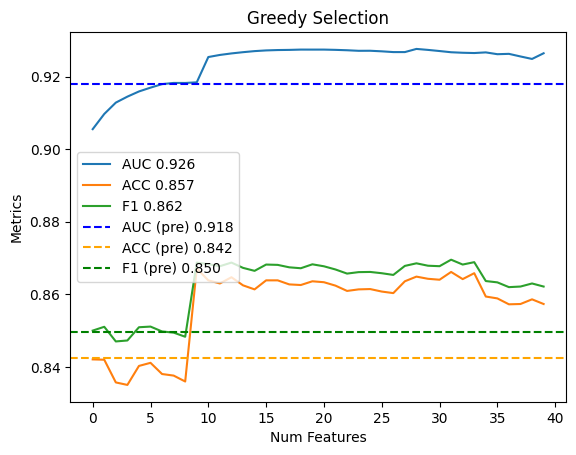

In [26]:
greedy_results = greedy_results_atomics

model = get_model(3)
train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

metrics = evaluate_classification(model, val_loader)

visualize_optimization_results(greedy_results, *metrics)


old_test_metrics = evaluate_classification(model, val_loader)

model.deactivate_bottleneck_weights_if_top_k()

new_test_metrics = evaluate_classification(model, val_loader)


In [24]:
greedy_results_atomics

,Score,Layer,Concept,Feature,acc,f1,auc
0,0.905524,0,1,24,0.842056,0.849996,0.905524
1,0.909714,0,3,17,0.841970,0.851043,0.909714
2,0.912844,0,3,22,0.835707,0.847008,0.912844
3,0.914490,0,0,17,0.835021,0.847272,0.914490
4,0.915918,0,1,15,0.840254,0.850921,0.915918
5,0.916970,0,3,6,0.841112,0.851101,0.916970
6,0.917938,0,0,3,0.838023,0.849753,0.917938
7,0.918268,0,1,18,0.837594,0.849439,0.918268
8,0.918259,0,3,21,0.835964,0.848302,0.918259
9,0.918433,0,0,10,0.867107,0.868740,0.918433


## Optimization Atomics

In [30]:
# feature weights
config_atomics = {
    "n_atomics": 10, # 30
    "n_concepts": 4, # 20
    "use_indicators": True,
    "use_fixes": False,
    "use_summaries_for_atomics": True,
}

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/atomics/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_atomics.keys()]) + "seed_{seed}.pt"

train_loader, val_loader, test_loader, class_weights, num_classes, changing_vars, static_names, seq_len = load_and_create_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = random_seed)

top_k = "" # "/workdir/optimal-summaries-public/_models/vasopressor/atomics/top-k/bottleneck_topkinds.csv"

model = initializeModel_with_atomics(**config_atomics, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=top_k)
model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config_atomics, seed = random_seed), max_epochs=10000)

evaluate_classification(model, test_loader, num_classes=num_classes, device=device)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
AUC macro 0.9138913750648499
ACC macro 0.8373948931694031
 F1 macro 0.8451417684555054


(0.9138913750648499, 0.8373948931694031, 0.8451417684555054)

In [32]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)

track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

for model in models:
    top_k_inds = [get_top_features_per_concept(layer) for layer in model.regularized_layers]

    greedy_results_atomics = greedy_forward_selection(model=model, layers_to_prune=model.regularized_layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, device=device, track_metrics=track_metrics)
    greedy_results_atomics


100%|██████████| 140/140 [12:42:48<00:00, 326.92s/it, Score=0.92425, acc=0.864, f1=0.867]  


,Score,Layer,Concept,Feature,acc,f1
0,0.902103,0,3,30,0.137440,0.137440
1,0.906148,0,3,9,0.137440,0.137440
2,0.906700,0,4,30,0.137440,0.137440
3,0.906894,0,3,31,0.137440,0.137440
4,0.907063,0,6,4,0.137440,0.137440
...,...,...,...,...,...,...
135,0.924249,1,2,257,0.863675,0.866884
136,0.924250,1,1,139,0.863675,0.866884
137,0.924250,1,1,239,0.863675,0.866884
138,0.924250,1,1,203,0.863675,0.866884


In [33]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_topkinds.csv" #_r{}_c{}   .format(random_seed, n_concepts)

import csv
# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results_atomics.columns)
    # writing the data rows 
    for row in greedy_results_atomics.itertuples(index=False):
        csvwriter.writerow(list(row))
